In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
Ft0 = 2
ct0 = 2
v = Ft0/ct0
y0 = np.array([0.5, 0.5, 0.0])
c0 = y0 * ct0
F0 = y0 * Ft0
Cp = 100.0
dh1 = -1800
dh3 = -1100
U = 16

In [3]:
def ode_system(w, y, Ta=500):
    T = y[0]
    c = y[1:]
    F = c * v
    k1 = 0.5 * np.exp(2 * (1 - 320 / T))
    Kc = 10 * np.exp(4.8 * (430 / T - 1.5))
    k2 = k1 / Kc
    k3 = 0.005 * np.exp(4.6 * (1 - 460 / T))
    r1 = - k1 * c[0] + k2 * c[1]
    r3 = - k3 * c[0]
    dc = np.array([r1 + r3, -r1, -r3]) / v
    rdh = r1 * dh1 + r3 * dh3
    dT = (U * (Ta - T) + rdh) / (F * Cp).sum()

    return np.hstack([dT, dc])

In [4]:
T0 = 330.0
y0 = np.hstack([T0, c0])
W = 100

In [5]:
sol_ode = solve_ivp(ode_system, (0, W), y0, method='RK45', t_eval=np.linspace(0, W, 200))

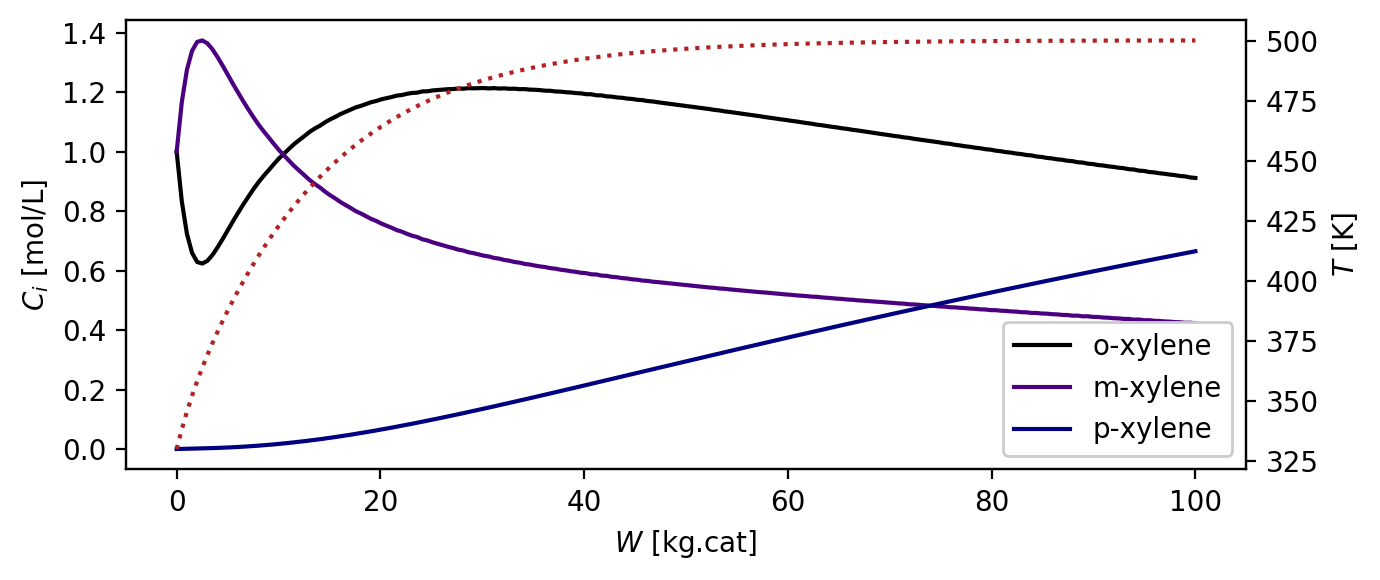

In [6]:
fig, ax1 = plt.subplots(figsize = (7, 3), dpi=200)

ax1.plot(sol_ode.t, sol_ode.y[1], color='black', label="o-xylene")
ax1.plot(sol_ode.t, sol_ode.y[2], color='indigo', label="m-xylene")
ax1.plot(sol_ode.t, sol_ode.y[3], color='navy', label="p-xylene")

ax1.set_ylabel(r'$C_i$ [mol/L]')
ax1.set_xlabel(r'$W$ [kg.cat]')
ax1.legend(loc="lower right", framealpha=1.0)

ax2 = ax1.twinx()
ax2.plot(sol_ode.t, sol_ode.y[0], color='firebrick', linestyle=":")
ax2.set_ylabel(r'$T$ [K]')

fig.tight_layout()

plt.show()

In [7]:
def obj_conv(x):

    W = x[0]
    T0 = x[1]
    Ta = x[2]

    y0 = np.hstack([T0, c0])

    sol_ode = solve_ivp(ode_system, (0, W), y0, method='RK45', args=(Ta,))

    y = sol_ode.y[:, -1]
    T = y[0]
    cox = y[1]
    cmx = y[2]
    cpx = y[3]

    xox = (cox - c0[0])
    xmx = (cmx - c0[1])
    xpx = (cpx - c0[2])

    return  - xox

def cons_func(x):

    W = x[0]
    T0 = x[1]
    Ta = x[2]

    y0 = np.hstack([T0, c0])

    sol_ode = solve_ivp(ode_system, (0, W), y0, method='RK45', args=(Ta,))

    y = sol_ode.y[:, -1]
    T = y[0]

    return  450 - T

In [8]:
bounds = [(0.1, 100), (200, 500), (200, 500)]

In [9]:
sol_bounded = minimize(obj_conv, np.array([50, 350, 500]), method="SLSQP", bounds=bounds)

In [10]:
sol_bounded

     fun: -0.21399542330490173
     jac: array([-2.09957361e-05, -4.35262918e-05, -2.52816081e-03])
 message: 'Optimization terminated successfully'
    nfev: 46
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([ 28.22683154, 348.24267266, 500.        ])

In [11]:
sol_constrained = minimize(obj_conv, np.array([50, 350, 500]), method="SLSQP", bounds=bounds,
                           constraints={"fun":cons_func, "type":"ineq"})

In [12]:
sol_constrained

     fun: -0.11430084694334797
     jac: array([-0.01059473, -0.00094861, -0.00354882])
 message: 'Optimization terminated successfully'
    nfev: 90
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([ 19.11326223, 347.06963499, 480.11359218])

In [13]:
def ode_from_opt(x, t_eval=None):

    W = x[0]
    T0 = x[1]
    Ta = x[2]

    y0 = np.hstack([T0, c0])

    sol_ode = solve_ivp(ode_system, (0, W), y0, method='RK45', args=(Ta,), t_eval=t_eval)

    return  sol_ode

In [14]:
sol_ode_bounded = ode_from_opt(sol_bounded.x, t_eval=np.linspace(0, sol_bounded.x[0], 200))
sol_ode_constrained = ode_from_opt(sol_constrained.x, t_eval=np.linspace(0, sol_constrained.x[0], 200))

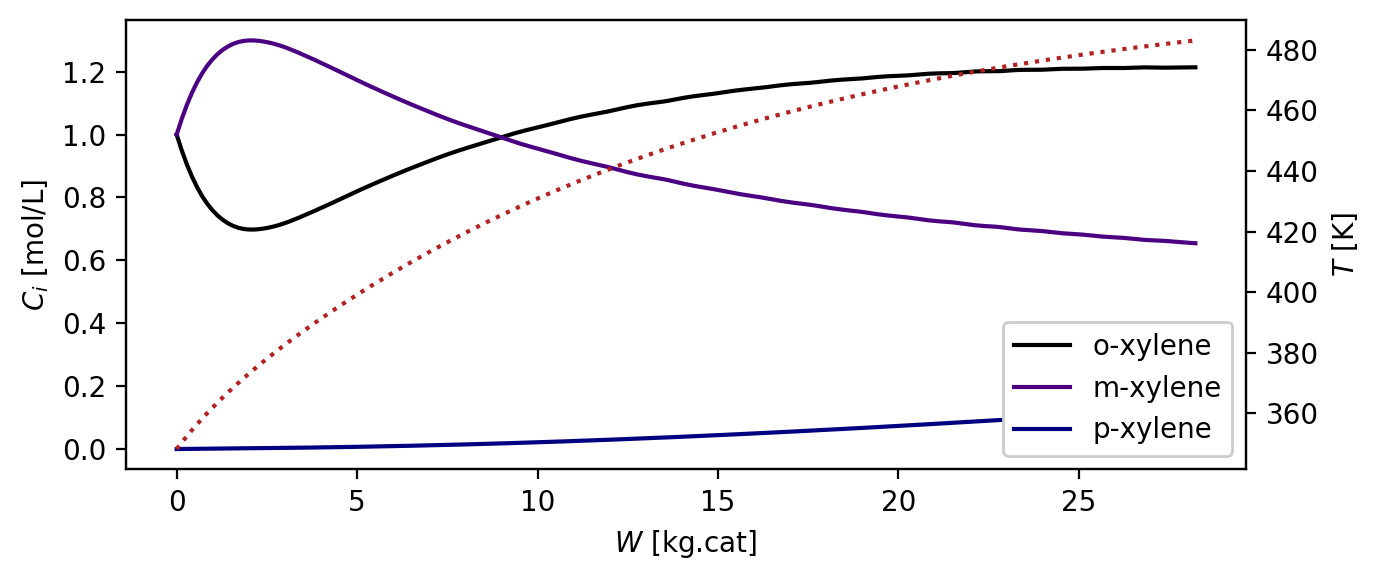

In [15]:
fig, ax1 = plt.subplots(figsize = (7, 3), dpi=200)

ax1.plot(sol_ode_bounded.t, sol_ode_bounded.y[1], color='black', label="o-xylene")
ax1.plot(sol_ode_bounded.t, sol_ode_bounded.y[2], color='indigo', label="m-xylene")
ax1.plot(sol_ode_bounded.t, sol_ode_bounded.y[3], color='navy', label="p-xylene")

ax1.set_ylabel(r'$C_i$ [mol/L]')
ax1.set_xlabel(r'$W$ [kg.cat]')
ax1.legend(loc="lower right", framealpha=1.0)

ax2 = ax1.twinx()
ax2.plot(sol_ode_bounded.t, sol_ode_bounded.y[0], color='firebrick', linestyle=":")
ax2.set_ylabel(r'$T$ [K]')

fig.tight_layout()

plt.show()